In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
import numpy as np
import scipy as sp
import time

sns.set()
plt.rcParams["figure.figsize"] = (8,8)

# Part A


Consider a FIR (finite impulse response) discrete time filter such that

$$
    x_n \sum\limits_{m=0}^{N_h-1} h_m g_{n-m}
$$

$x_n$ is the filter output, $h_m$ are the FIR filter coefficients and, $g_n$ is the input excitation sequence which is assumed to be known. It is convenient if it is a white noise sequence of normal random samples of unit variance and zero mean. A common problem is that $x_n$ is corrupted by additive noise such that the actual observation is


$$
    x_n \sum\limits_{m=0}^{N_h-1} h_m g_{n-m} + w_n
$$

where

$$
    w \sim \mathcal{N}(0, \sigma^2)
$$

Write a routine that estimates the values of $h_m$ given an input excitation sequence of $g_n$ that is assumed to be known and with
$w_n$ as iid (independent and identically distributed) zero mean Gaussian with
$\sigma^2 = 0.1$. Try out your routine with the filter coefficients of: `h = [1,2,-1,4,1]`;

In [2]:
N = 1000
h = np.array([1, 2, -1, 4, 1])
g = np.random.randn(N)
sigma = 0.1

x_conv = sp.signal.convolve(g, h)
H = np.zeros((N + len(h) - 1, len(h)))

In [3]:
for n in range(N + len(h)):
    for m in range(len(h)):
        g_idx = n - m
        if 0 <= g_idx < N:
            H[n,m] = g[g_idx]

In [4]:
x_H = H @ h.T

In [5]:
np.sum(x_H - x_conv)

-1.0158540675320182e-14

In [6]:
x = H @ h.T
x += np.random.randn(*x.shape) * sigma

### The least squares solution

The least squares solution is:
$$
    \hat h = \hat \theta = (H^T H)^{-1} H^T x
$$

In [7]:
h_hat = (np.linalg.inv(H.T @ H)) @ H.T @ x

In [8]:
# All values should be close
h, h_hat

(array([ 1,  2, -1,  4,  1]),
 array([ 0.99698539,  1.99971115, -0.99969673,  4.00214267,  1.0030392 ]))

# General Functions

In [46]:
# Create function that will be used to rerun experiment several times

def gen_H(N=1000, h=np.array([1, 2, -1, 4, 1]), g=None):
    if g is None:
        g = np.random.randn(N)

    # Generate H
    H = np.zeros((N + len(h) - 1, len(h)))
    for n in range(N + len(h)):
        for m in range(len(h)):
            g_idx = n - m
            if 0 <= g_idx < N:
                H[n,m] = g[g_idx]
    return H


def gen_x(H, h=np.array([1, 2, -1, 4, 1]), Q=None, sigma=None):
    # Create a x ~ N(sum(h_m * g_{n-m}), Q)
    x = H @ h.T  # Mean of samples

    if sigma is not None:
        x += np.random.randn(*x.shape) * sigma
    elif Q is not None:
        x = np.random.multivariate_normal(x, Q)
    else:
        raise ArgumentError('One of [Q, sigma] must be given')

    return x


def matched_filter(H, x, Q_inv=None):
    return (np.linalg.inv(H.T @ H)) @ H.T @ x
        

def run_experiment(h=np.array([1, 2, -1, 4, 1]), h_hat_fn=matched_filter, g=None, k=1000, N=1000, Q=None, sigma=None):
    '''Using a certain h (and optionally g) run the experiment k times.'''
    h_hats = np.zeros((k, len(h)))
    for i in range(k):
        H = gen_H(N=N)
        x = gen_x(H=H, h=h, Q=Q, sigma=sigma)
        h_hats[i,:] = h_hat_fn(H=H, x=x)
    return h_hats
    
        
def calc_avg_deviation(h, h_hats):
    return np.mean(np.abs(h_hats - h), axis=0)


In [11]:
# Calculate the avg deviation from 100 runs
h_hats = run_experiment(np.array([1, 2, -1, 4, 1]), matched_filter, k=1000, N=1000, sigma=0.1)
avg_dev = calc_avg_deviation(h, h_hats)

In [12]:
avg_dev

array([0.00256553, 0.00252203, 0.002464  , 0.00249351, 0.00264032])

# Part B

What is the expected deviation of the FIR coefficients in part A based on Fisher Information assuming that N=1000 data samples are used. Is there agreement?

In [107]:
N = 1000  # Number of elements in x
h = np.array([1, 2, -1, 4, 1])
k = 100  # Number of times to run the experiment
sigma = 0.1

exp_devs = np.zeros((k, len(h)))
fisher_devs = np.zeros((k, len(h)))

for i in range(k):
    H = gen_H(N, h=h)
    x = gen_x(H, h, sigma=sigma)
    
    h_hat = matched_filter(H, x)
    exp_devs[i,:] = np.abs(h - h_hat)
    
    J = H.T @ H / (sigma**2) # Equivalent to the H^T Q^{-1} H since Q is diagonal
    fisher_devs[i,:] = np.sqrt(np.diag(np.linalg.inv(J)))

print(f'Experimental deviation: {np.mean(exp_devs, axis=0)}')
print(f'Expected     deviation: {np.mean(fisher_devs, axis=0)}')


Experimental deviation: [0.00265219 0.00252775 0.00218602 0.00251256 0.0025855 ]
Expected     deviation: [0.00316098 0.00316085 0.00316084 0.00316085 0.00316098]


# Part C

In [49]:
seq_len = H.shape[0]
Q_c = np.zeros((seq_len, seq_len))

# Generate new covariance
for n in range(seq_len):
    for m in range(seq_len):
        Q_c[n,m] = sigma**2 * np.exp(-np.abs(m-n))
        
Q_c_inv = np.linalg.inv(Q_c)

# Check that the first few elements of the covariance is what we expect (diagonals = 0.1, drop off exponentially on off-diag elements)
print(Q_c[:5,:5])

[[0.01       0.00367879 0.00135335 0.00049787 0.00018316]
 [0.00367879 0.01       0.00367879 0.00135335 0.00049787]
 [0.00135335 0.00367879 0.01       0.00367879 0.00135335]
 [0.00049787 0.00135335 0.00367879 0.01       0.00367879]
 [0.00018316 0.00049787 0.00135335 0.00367879 0.01      ]]


In [50]:
# Generate new data with the new covariance
x = H @ h.T
x = np.random.multivariate_normal(x, Q_c)

In [51]:
h_hat_gmf = (np.linalg.inv(H.T @ Q_c_inv @ H)) @ H.T @ Q_c_inv @ x

print(h_hat_gmf)

[ 0.99253218  1.98865563 -0.99587199  3.99939895  1.00979686]


## Plot comparisons of MF, GMF, CRLB over a range of $0.001 \leq \sigma^2 \leq 1$

In [52]:
np.sqrt(10**np.linspace(-3, 0, 100))

array([0.03162278, 0.03274549, 0.03390807, 0.03511192, 0.03635851,
       0.03764936, 0.03898604, 0.04037017, 0.04180345, 0.04328761,
       0.04482447, 0.04641589, 0.04806381, 0.04977024, 0.05153725,
       0.05336699, 0.0552617 , 0.05722368, 0.05925531, 0.06135907,
       0.06353753, 0.06579332, 0.06812921, 0.07054802, 0.07305272,
       0.07564633, 0.07833203, 0.08111308, 0.08399287, 0.0869749 ,
       0.0900628 , 0.09326033, 0.09657139, 0.1       , 0.10355034,
       0.10722672, 0.11103363, 0.1149757 , 0.11905772, 0.12328467,
       0.12766169, 0.13219411, 0.13688745, 0.14174742, 0.14677993,
       0.15199111, 0.1573873 , 0.16297508, 0.16876125, 0.17475284,
       0.18095715, 0.18738174, 0.19403442, 0.2009233 , 0.20805675,
       0.21544347, 0.22309244, 0.23101297, 0.23921471, 0.24770764,
       0.25650209, 0.26560878, 0.27503878, 0.28480359, 0.29491507,
       0.30538555, 0.31622777, 0.32745492, 0.33908067, 0.35111917,
       0.36358509, 0.37649358, 0.38986037, 0.40370173, 0.41803

In [57]:
def gen_Q_c(sigma2, seq_len):
    Q_c = np.zeros((seq_len, seq_len))

    # Generate new covariance
    for n in range(seq_len):
        for m in range(seq_len):
            Q_c[n,m] = sigma2 * np.exp(-np.abs(m-n))

    Q_c_inv = np.linalg.inv(Q_c)
    
    return Q_c, Q_c_inv

def gmf(H, x, Q_inv):
    return (np.linalg.inv(H.T @ Q_inv @ H)) @ H.T @ Q_inv @ x

In [91]:
N = 100  # Number of elements in x
h = np.array([1, 2, -1, 4, 1])
k = 100  # Number of times to run the experiment for each value of sigma^2
sigma2s = 10**np.linspace(-3, 0, 100)  # Allows for more samples at small sigma^2, because why not?
sigma2s = np.linspace(0.001, 1, 100)  # Allows for more samples at small sigma^2, because why not?
seq_len = gen_H(N, h=h).shape[0]

avg_devs_mf = np.zeros(sigma2s.shape + h.shape)
avg_devs_gmf = np.zeros(sigma2s.shape + h.shape)
avg_fisher_devs = np.zeros(sigma2s.shape + h.shape)

for j, sigma2 in enumerate(sigma2s):
    fisher_devs = np.zeros((k, len(h)))
    exp_devs_mf = np.zeros((k, len(h)))
    exp_devs_gmf = np.zeros((k, len(h)))
    Q_c, Q_c_inv = gen_Q_c(sigma2, seq_len)

    for i in range(k):
        H = gen_H(N, h=h)
        x = gen_x(H, h, Q=Q_c)

        J = H.T @ Q_c_inv @ H
        fisher_devs[i,:] = np.sqrt(np.diag(np.linalg.inv(J)))

        exp_devs_mf[i,:] = np.abs(h - matched_filter(H, x))
        exp_devs_gmf[i,:] = np.abs(h - gmf(H, x, Q_inv=Q_c_inv))

    avg_devs_mf[j,:] = np.mean(exp_devs_mf, axis=0)
    avg_devs_gmf[j,:] = np.mean(exp_devs_gmf, axis=0)
    avg_fisher_devs[j,:] = np.mean(fisher_devs, axis=0)


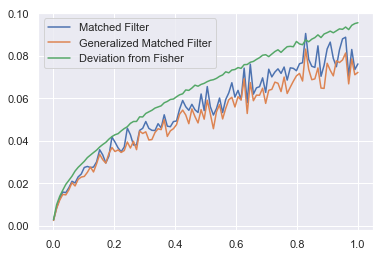

In [97]:
# Plot deviations for the frist element of h
plt.plot(sigma2s, avg_devs_mf[:,0], label='Matched Filter')
plt.plot(sigma2s, avg_devs_gmf[:,0], label='Generalized Matched Filter')
plt.plot(sigma2s, avg_fisher_devs[:,0], label='Deviation from Fisher')
plt.legend()
plt.show()

## Discussion

This result makes sense due to the nature of the covariance matrix the variance between the diagonal matrix from part A and the updated convariance from this part you see that with larger values of $\sigma$ the difference between the two estimators (in absolute terms) will increase over time. 

The variance of the MF is going to be some percentage higher than the GMF and this trend is pretty consistent throughout the range of $\sigma$s

# Part D

In [98]:
def gen_Q_d(sigma2, seq_len):
    Q_d = np.zeros((seq_len, seq_len))

    # Generate new covariance
    for n in range(seq_len):
        for m in range(seq_len):
            Q_d[n,m] = sigma2 * np.exp(-0.1 * np.abs(m-n))

    Q_d_inv = np.linalg.inv(Q_d)
    
    return Q_d, Q_d_inv

def gmf(H, x, Q_inv):
    return (np.linalg.inv(H.T @ Q_inv @ H)) @ H.T @ Q_inv @ x

In [99]:
N = 100  # Number of elements in x
h = np.array([1, 2, -1, 4, 1])
k = 100  # Number of times to run the experiment for each value of sigma^2
sigma2s = 10**np.linspace(-3, 0, 100)  # Allows for more samples at small sigma^2, because why not?
sigma2s = np.linspace(0.001, 1, 100)  # Allows for more samples at small sigma^2, because why not?
seq_len = gen_H(N, h=h).shape[0]

avg_devs_mf = np.zeros(sigma2s.shape + h.shape)
avg_devs_gmf = np.zeros(sigma2s.shape + h.shape)
avg_fisher_devs = np.zeros(sigma2s.shape + h.shape)

for j, sigma2 in enumerate(sigma2s):
    fisher_devs = np.zeros((k, len(h)))
    exp_devs_mf = np.zeros((k, len(h)))
    exp_devs_gmf = np.zeros((k, len(h)))
    Q_d, Q_d_inv = gen_Q_d(sigma2, seq_len)

    for i in range(k):
        H = gen_H(N, h=h)
        x = gen_x(H, h, Q=Q_d)

        J = H.T @ Q_d_inv @ H
        fisher_devs[i,:] = np.sqrt(np.diag(np.linalg.inv(J)))

        exp_devs_mf[i,:] = np.abs(h - matched_filter(H, x))
        exp_devs_gmf[i,:] = np.abs(h - gmf(H, x, Q_inv=Q_d_inv))

    avg_devs_mf[j,:] = np.mean(exp_devs_mf, axis=0)
    avg_devs_gmf[j,:] = np.mean(exp_devs_gmf, axis=0)
    avg_fisher_devs[j,:] = np.mean(fisher_devs, axis=0)


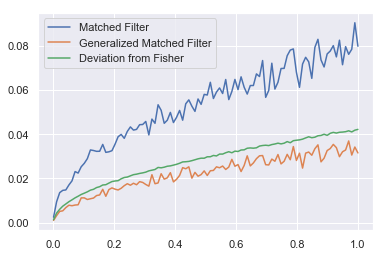

In [100]:
# Plot deviations for the frist element of h
plt.plot(sigma2s, avg_devs_mf[:,0], label='Matched Filter')
plt.plot(sigma2s, avg_devs_gmf[:,0], label='Generalized Matched Filter')
plt.plot(sigma2s, avg_fisher_devs[:,0], label='Deviation from Fisher')
plt.legend()
plt.show()

# Discussion

In the graphs we can see the drastic difference of increasing the off-diagonal elements of the covariance matrix on the performance of the MF vs GMF.

This is to be expected, since the GMF takes into account the entire covariance matrix this signifcantly improves performance when you have a covariance matrix with large off-diagonal elements.

# Part E

In [108]:
# New h, everything else stays constant as in D
h = np.exp(-0.1*(np.arange(0,14)))

N = 100  # Number of elements in x
k = 100  # Number of times to run the experiment for each value of sigma^2
sigma2s = 10**np.linspace(-3, 0, 100)  # Allows for more samples at small sigma^2, because why not?
sigma2s = np.linspace(0.001, 1, 100)  # Allows for more samples at small sigma^2, because why not?
seq_len = gen_H(N, h=h).shape[0]

avg_devs_mf = np.zeros(sigma2s.shape + h.shape)
avg_devs_gmf = np.zeros(sigma2s.shape + h.shape)
avg_fisher_devs = np.zeros(sigma2s.shape + h.shape)

for j, sigma2 in enumerate(sigma2s):
    fisher_devs = np.zeros((k, len(h)))
    exp_devs_mf = np.zeros((k, len(h)))
    exp_devs_gmf = np.zeros((k, len(h)))
    Q_d, Q_d_inv = gen_Q_d(sigma2, seq_len)

    for i in range(k):
        H = gen_H(N, h=h)
        x = gen_x(H, h, Q=Q_d)

        J = H.T @ Q_d_inv @ H
        fisher_devs[i,:] = np.sqrt(np.diag(np.linalg.inv(J)))

        exp_devs_mf[i,:] = np.abs(h - matched_filter(H, x))
        exp_devs_gmf[i,:] = np.abs(h - gmf(H, x, Q_inv=Q_d_inv))

    avg_devs_mf[j,:] = np.mean(exp_devs_mf, axis=0)
    avg_devs_gmf[j,:] = np.mean(exp_devs_gmf, axis=0)
    avg_fisher_devs[j,:] = np.mean(fisher_devs, axis=0)


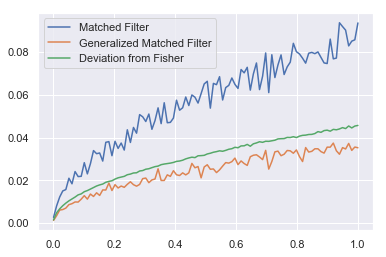

In [109]:
# Plot deviations for the frist element of h
plt.plot(sigma2s, avg_devs_mf[:,0], label='Matched Filter')
plt.plot(sigma2s, avg_devs_gmf[:,0], label='Generalized Matched Filter')
plt.plot(sigma2s, avg_fisher_devs[:,0], label='Deviation from Fisher')
plt.legend()
plt.show()